In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FactorAnalysis

from tqdm import tqdm, trange
import plotly.io as pio
import plotly.express as px
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.style.use('seaborn-paper')
comp = ["Component_"+str(i) for i in range(3)]
name = ["Acoustics-energy Component", "Valence Component", "Instrumental Component"]

In [2]:
raw_influence_data = pd.read_csv("influence_data.csv")
m = np.shape(raw_influence_data)[0]
musician_dict = dict()
# counts = raw_influence_data["follower_id"].value_counts()

for i in range(m):
    g1 = raw_influence_data["influencer_main_genre"][i]
    g2 = raw_influence_data["follower_main_genre"][i]
    artist1 = raw_influence_data["influencer_id"][i]
    artist2 = raw_influence_data["follower_id"][i]
    if musician_dict.get(artist1, -1) == -1:
        musician_dict[artist1] = g1
    if musician_dict.get(artist2, -1) == -1:
        musician_dict[artist2] = g2

In [3]:
info_columns = ["danceability", "energy", "valence", "tempo", "loudness", "mode", "key", "acousticness",
                "instrumentalness", "liveness", "speechiness", "duration_ms"]

raw_full_data = pd.read_csv("full_music_data.csv")
artists_id = raw_full_data["artists_id"].values
genre_list = []
n = np.shape(artists_id)[0]
for i in range(n):
    temp, flag = artists_id[i][1:-1].split(','), False
    for x in temp:
        if musician_dict.get(int(x.lstrip(' ')), -1) != -1:
            genre_list.append(musician_dict[int(x.lstrip(' '))])
            flag = True
            break
    if not flag:
        genre_list.append("Unknown")

genres = pd.unique(genre_list)
n_genres = len(genres)

In [4]:
raw_data_artist = pd.read_csv("data_by_artist.csv")

scaler = MinMaxScaler()
X = scaler.fit_transform(raw_data_artist[info_columns].values)

dimension_reducer = load("P2_FA.joblib")
Z = dimension_reducer.transform(X)

In [5]:
musician_embedding = dict()
musician_features = dict()
genre_dict = {g: [] for g in genres}

for i in range(np.shape(raw_data_artist)[0]):
    if musician_dict.get(raw_data_artist["artist_id"][i], -1) != -1:
        musician_embedding[raw_data_artist["artist_id"][i]] = Z[i, :]
        musician_features[raw_data_artist["artist_id"][i]] = X[i, :]
        genre_dict[musician_dict[raw_data_artist["artist_id"][i]]].append(raw_data_artist["artist_id"][i])

In [27]:
##### temp = raw_full_data["year"].values
temp = temp.reshape((temp.shape[0], 1))
X_ = MinMaxScaler().fit_transform(raw_full_data[info_columns].values)
Z_ = dimension_reducer.transform(X_)
new_data = np.hstack((temp, np.reshape(genre_list, (len(genre_list), 1)).astype(object), Z_))

new_data = pd.DataFrame(new_data, index = raw_full_data.index, \
                        columns = ["year", "genre"] + ["Component_"+str(i) for i in [0, 1, 2]], dtype = object)
new_data

,year,genre,Component_0,Component_1,Component_2
0,2005,Electronic,0.711613,1.35852,0.190009
1,2005,Electronic,0.838388,1.06997,-0.616891
2,2009,Electronic,0.0465882,0.794521,-0.299105
3,1991,R&B;,-0.695823,-1.02954,-0.242422
4,1987,R&B;,-1.15617,-1.02996,0.991825
...,...,...,...,...,...
98335,1975,Pop/Rock,-1.35174,-0.123036,0.675505
98336,1976,Pop/Rock,-0.305275,-1.42786,-0.10848
98337,1987,Pop/Rock,-0.716973,-1.07521,0.293699
98338,1992,Pop/Rock,-0.433674,0.190241,0.140794


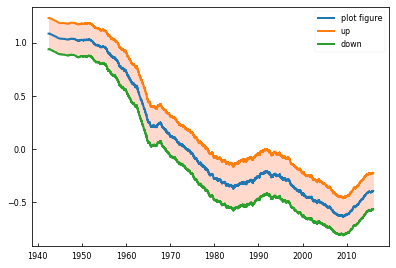

In [30]:
import matplotlib.pyplot as plt
import numpy as np

new_data = new_data.sort_values(by='year')
x = new_data['year'].rolling(window=5000).mean()
y = new_data['Component_0'].rolling(window=5000).mean()

plt.plot(x, y, ls="-", lw=2, label="plot figure")

std = new_data['Component_0'].rolling(window=5000).std()
mean = new_data['Component_0'].rolling(window=5000).mean()

x_up = new_data['year'].rolling(window=5000).mean()
y_up = mean + 0.22*std

plt.plot(x_up, y_up, ls="-", lw=2, label="up")


x_down = new_data['year'].rolling(window=5000).mean()
y_down = mean - 0.22*std

plt.plot(x_down, y_down, ls="-", lw=2, label="down")

plt.fill_between(x_down, y_down, y_up, y_up > y_down, color='orangered', alpha=0.2)

plt.legend()

plt.show()
